## German Traffic Sign Recognition Classifier
- National Cheng Kung University Electrical Engineering
- Student: Eason Chen
- ID: E24094198
- Goal: Try to train a LaNet5 for recognizing German traffic sign, and then test the model with some online found German traffic sign images

### Step 0: Load the Data stored in p-coded file

In [1]:
# load data using pickle
import pickle

train_file='./traffic-signs-data/train.p'
valid_file='./traffic-signs-data/valid.p'
test_file='./traffic-signs-data/test.p'

with open(train_file, mode='rb') as f:
    train=pickle.load(f)
with open(valid_file, mode='rb') as f:
    valid=pickle.load(f)
with open(test_file, mode='rb') as f:
    test=pickle.load(f)

x_train, y_train=train['features'], train['labels']
x_valid, y_valid=valid['features'], valid['labels']
x_test, y_test=test['features'], test['labels']

### Step 1: Dataset Summary & Exploration

#### Show the basic info of images and dataset

In [2]:
# show some basic dataset informations
import numpy as np

# count of training data, testing data and validation data
n_train=x_train.shape[0]
n_valid=x_valid.shape[0]
n_test=x_test.shape[0]

# shape of a traffic sign image
image_shape=x_train.shape[1:]

# count of classes in the dataset
n_classes=len(np.unique(y_train))

print(f'Count of training data: {n_train}')
print(f'Count of validation data: {n_valid}')
print(f'Count of testing data: {n_test}')
print(f'Image shape: {image_shape}')
print(f'Count of classes: {n_classes}')

Count of training data: 34799
Count of validation data: 4410
Count of testing data: 12630
Image shape: (32, 32, 3)
Count of classes: 43


#### Randomly show several classes of traffic signs

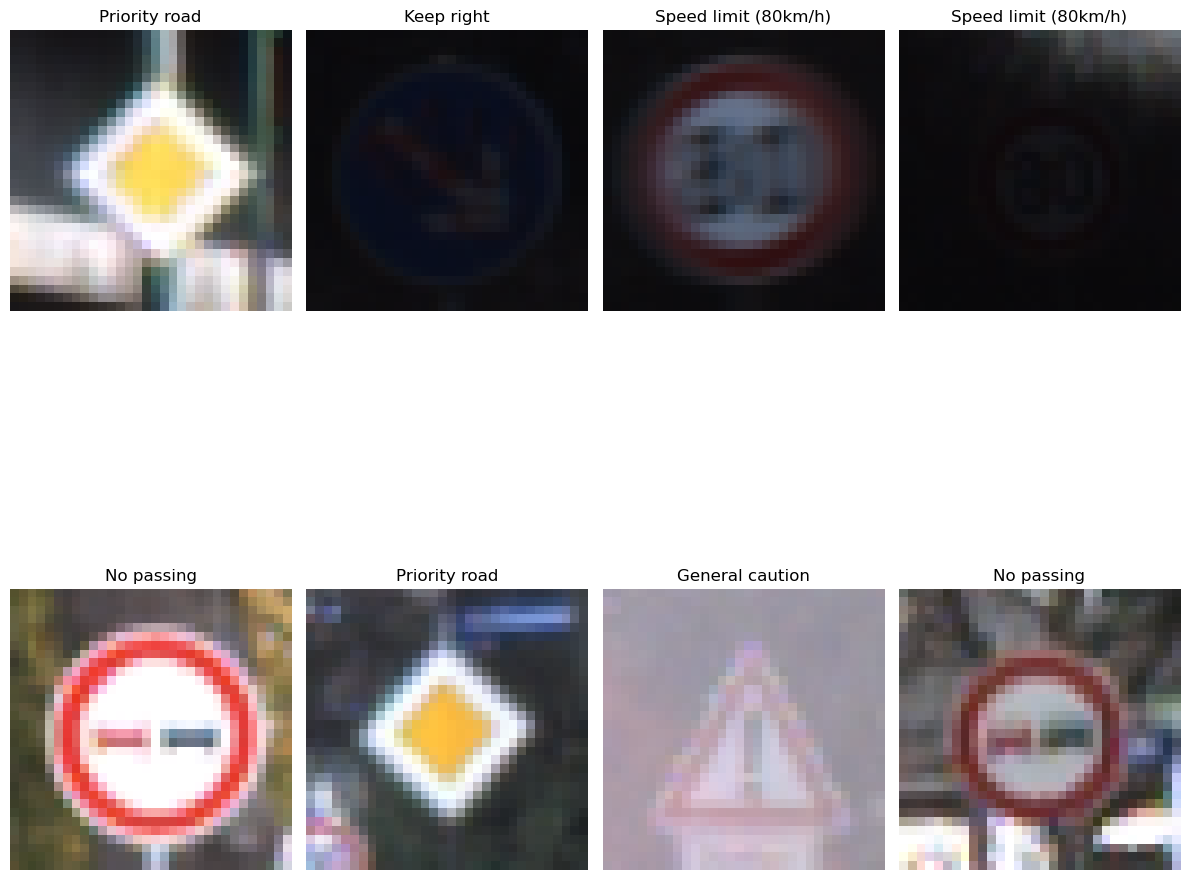

In [3]:
# randomly show different types of traffic sign with corresponding class name
import matplotlib.pyplot as plt
%matplotlib inline
import random

def plot_figures(figures, n_rows=1, n_cols=1, labels=None):
    fig, axes=plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(12,14))
    axes=axes.ravel()
    for index, title in zip(range(len(figures)), figures):
        axes[index].imshow(figures[title], plt.gray())
        if labels!=None:
            axes[index].set_title(labels[index])
        else:
            axes[index].set_title(title)
        axes[index].set_axis_off()
    plt.tight_layout()

name_values=np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'),('mtstring','S55')], delimiter=',')

count_to_show=8
figures={}
labels={}
random_signs=[] # record the random picked images' indices
for i in range(count_to_show):
    index=random.randint(0, n_train-1)
    labels[i]=name_values[y_train[index]][1].decode('ascii')
    figures[i]=x_train[index]
    random_signs.append(index)

plot_figures(figures, 2, 4, labels)

#### Show the class distribution in each dataset

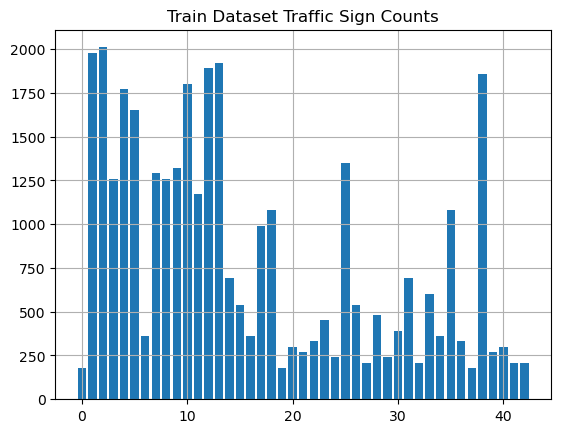

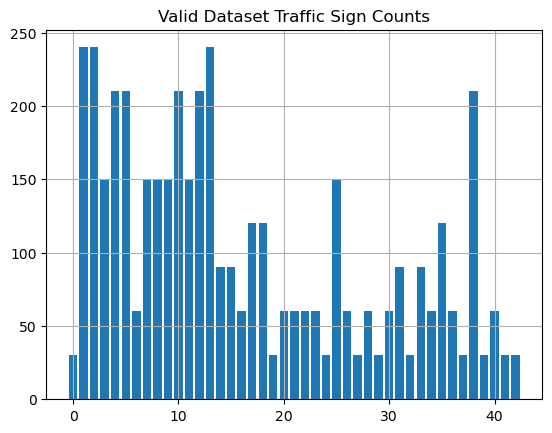

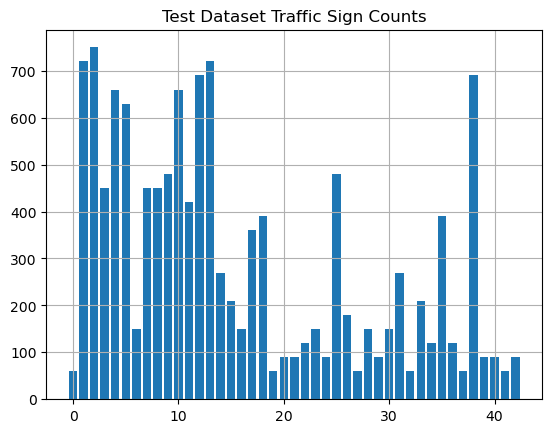

In [4]:
unique_train, counts_train=np.unique(y_train, return_counts=True)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title('Train Dataset Traffic Sign Counts')
plt.show()

unique_valid, counts_valid=np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, counts_valid)
plt.grid()
plt.title('Valid Dataset Traffic Sign Counts')
plt.show()

unique_test, counts_test=np.unique(y_test, return_counts=True)
plt.bar(unique_test, counts_test)
plt.grid()
plt.title('Test Dataset Traffic Sign Counts')
plt.show()

### Step 2: Preprocess Dataset(including normalize, grayscale, data_augmentation...)

#### Convert Images to Grayscale

In [5]:
# preprocess dataset (including normalization, converting to grayscale...)
x_train_RGB=x_train
x_train_gray=np.sum(x_train/3, axis=3, keepdims=True)

x_valid_RGB=x_valid
x_valid_gray=np.sum(x_valid/3, axis=3, keepdims=True)

x_test_RGB=x_test
x_test_gray=np.sum(x_test/3, axis=3, keepdims=True)

print(f'x_train_RGB shape: {x_train_RGB.shape}')
print(f'x_train_gray shape: {x_train_gray.shape}')

x_train_RGB shape: (34799, 32, 32, 3)
x_train_gray shape: (34799, 32, 32, 1)


In [6]:
x_train=x_train_gray
x_valid=x_valid_gray
x_test=x_test_gray

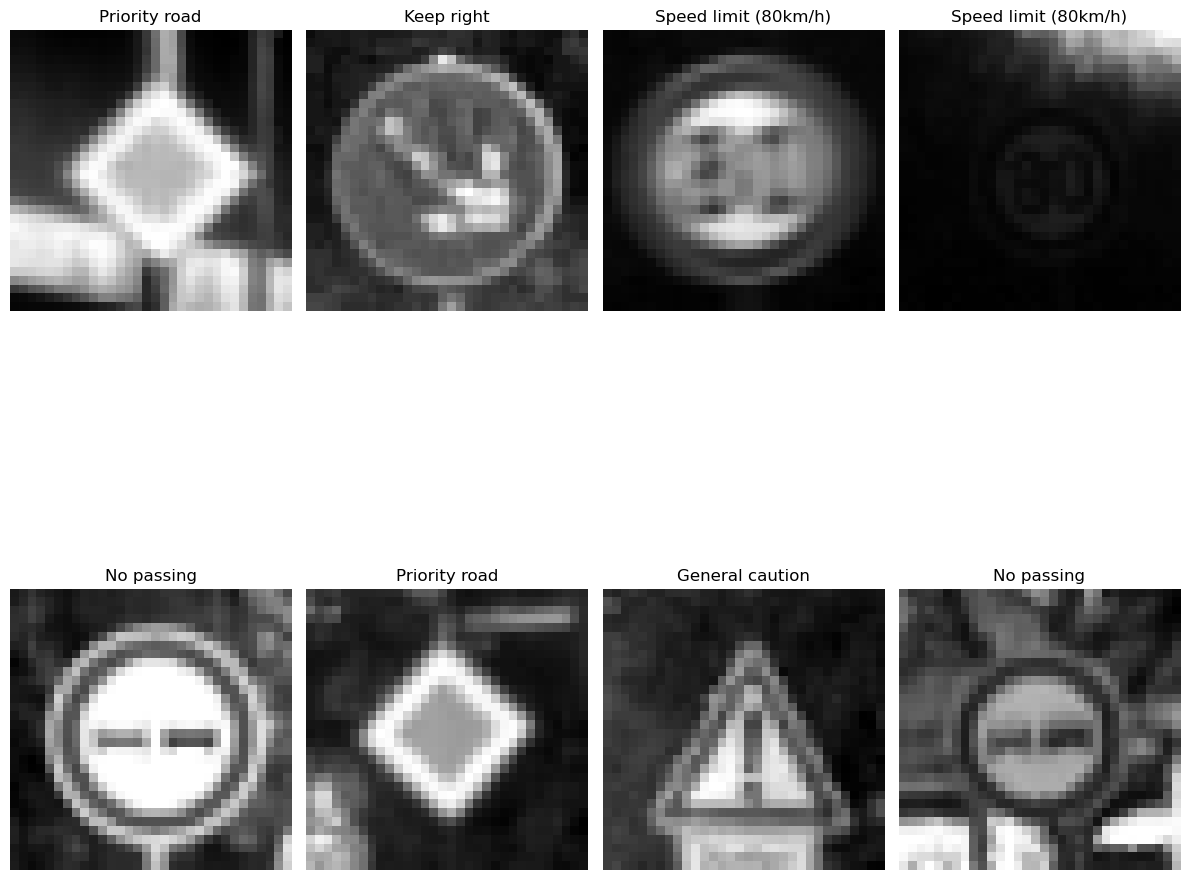

In [7]:
count_to_show=8
figures={}
count=0
for i in random_signs:
    labels[count]=name_values[y_train[i]][1].decode('ascii')
    figures[count]=x_train[i].squeeze()
    count+=1

plot_figures(figures, 2, 4, labels)

#### Data Augmentation for More Training Data(Affine/Perspective)

In [8]:
import cv2

# apply Affine tranformation and Perspective transformation and Rotation for Data Augmentation
affine_x=[]
affine_y=[]
perspective_x=[]
perspective_y=[]
rotate_x=[]
rotate_y=[]
new_counts_train=counts_train

# start apply data augmentation
for i in range(n_train):
    if(new_counts_train[y_train[i]]<3000):
        for j in range(3):
            # Affine Transformation(random translation)
            dx, dy=np.random.randint(-1.7, 1.8, 2)
            M=np.float32([[1, 0, dx],[0, 1, dy]])
            dst=cv2.warpAffine(x_train[i], M, (x_train[i].shape[0], x_train[i].shape[1]))
            dst=dst[:,:,None]
            affine_x.append(dst)
            affine_y.append(y_train[i])

            # Perspective Transformation
            high_bound=random.randint(22, 32)
            low_bound=random.randint(0, 12)
            points_one=np.float32([[0,0], [32,0], [0,32], [32,32]])
            points_two=np.float32([[0,0], [high_bound, low_bound], [low_bound, 32], [32, high_bound]])
            M=cv2.getPerspectiveTransform(points_one, points_two)
            dst=cv2.warpPerspective(x_train[i], M, (32, 32))
            perspective_x.append(dst)
            perspective_y.append(y_train[i])

            # Rotation
            tilt=random.randint(-15, 15)
            M=cv2.getRotationMatrix2D((x_train[i].shape[0]/2, x_train[i].shape[1]/2), tilt, 1)
            dst=cv2.warpAffine(x_train[i], M, (x_train[i].shape[0], x_train[i].shape[1]))
            rotate_x.append(dst)
            rotate_y.append(y_train[i])

            new_counts_train[y_train[i]]+=2

# convert to numpy array and reshape if necessary
affine_x=np.array(affine_x)
affine_y=np.array(affine_y)
perspective_x=np.array(perspective_x)
perspective_x=np.reshape(perspective_x, (np.shape(perspective_x)[0], 32, 32, 1))
perspective_y=np.array(perspective_y)
rotate_x=np.array(rotate_x)
rotate_x=np.reshape(rotate_x, (np.shape(rotate_x)[0], 32, 32, 1))
rotate_y=np.array(rotate_y)

# concatenate the augmented dataset into original data
x_train=np.concatenate((x_train, affine_x), axis=0)
x_train=np.concatenate((x_train, perspective_x), axis=0)
x_train=np.concatenate((x_train, rotate_x), axis=0)
y_train=np.concatenate((y_train, affine_y), axis=0)
y_train=np.concatenate((y_train, perspective_y), axis=0)
y_train=np.concatenate((y_train, rotate_y), axis=0)

# Since we have some augmented data within dataset, so the validation dataset should also contain some of augmented data
# so we combine the valid dataset and train dataset temporarily
# and use train_test_split to seperate the dataset later
x_train=np.concatenate((x_train, x_valid), axis=0)
y_train=np.concatenate((y_train, y_valid), axis=0)


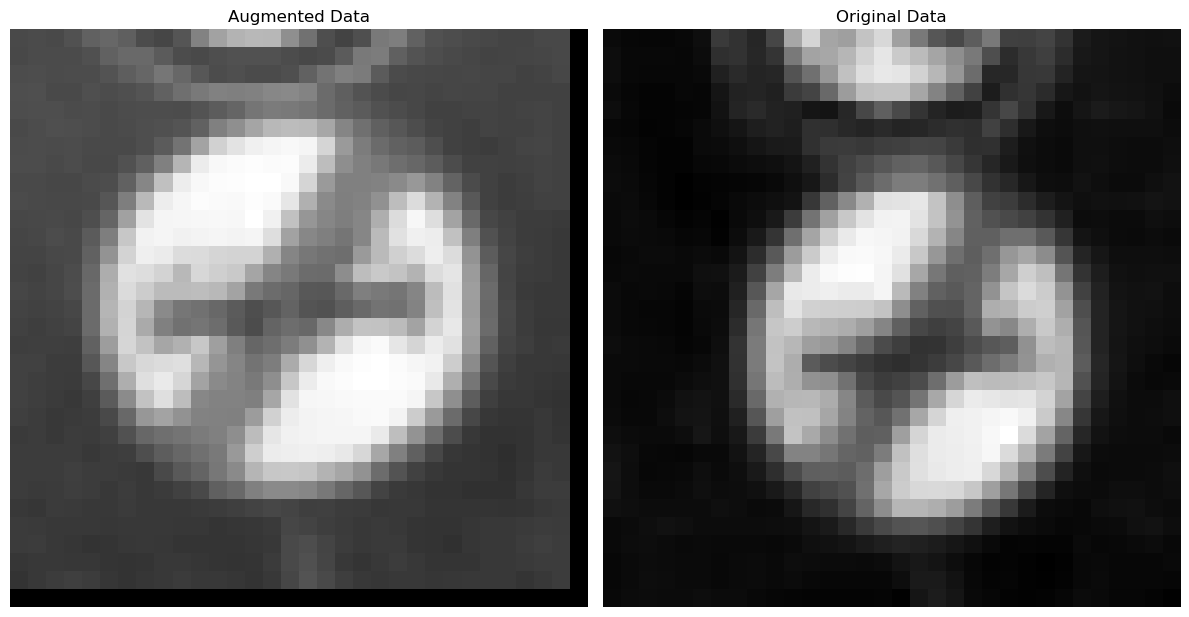

In [9]:
# display the augmented data compared with the orginal data
figure={}
label={}
figure[0]=x_train[n_train+50].squeeze()
label[0]="Augmented Data"
figure[1]=x_train[0].squeeze()
label[1]="Original Data"

plot_figures(figure, 1, 2, label)

#### Apply train_test_split to split validation dataset from training dataset

New Dataset Size : 119106


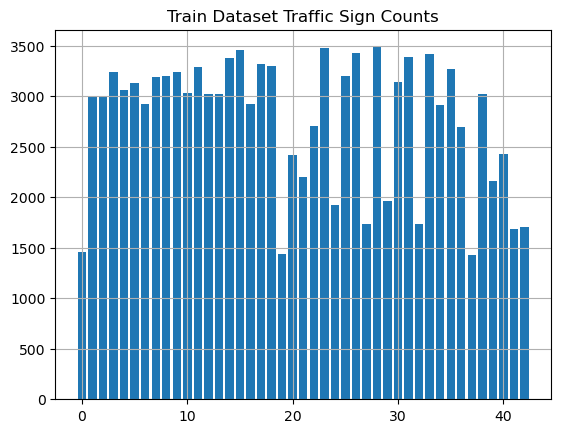

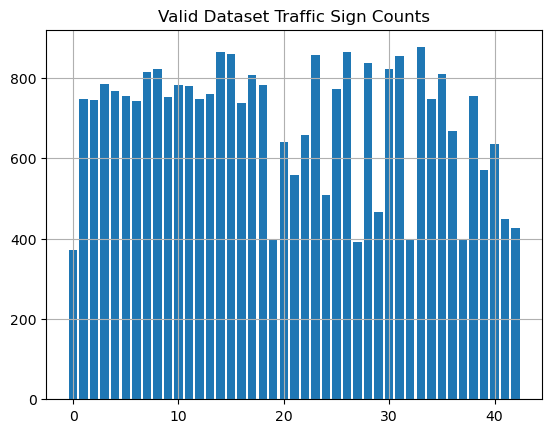

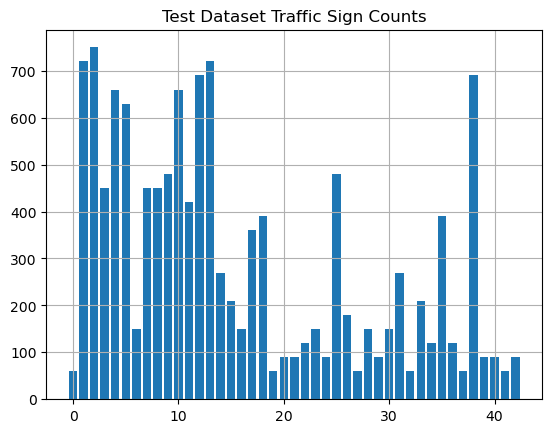

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("New Dataset Size : {}".format(x_train.shape[0]))

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Train Dataset Traffic Sign Counts")
plt.show()

unique, counts = np.unique(y_valid, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Valid Dataset Traffic Sign Counts")
plt.show()

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.grid()
plt.title("Test Dataset Traffic Sign Counts")
plt.show()


#### Normalize the Dataset

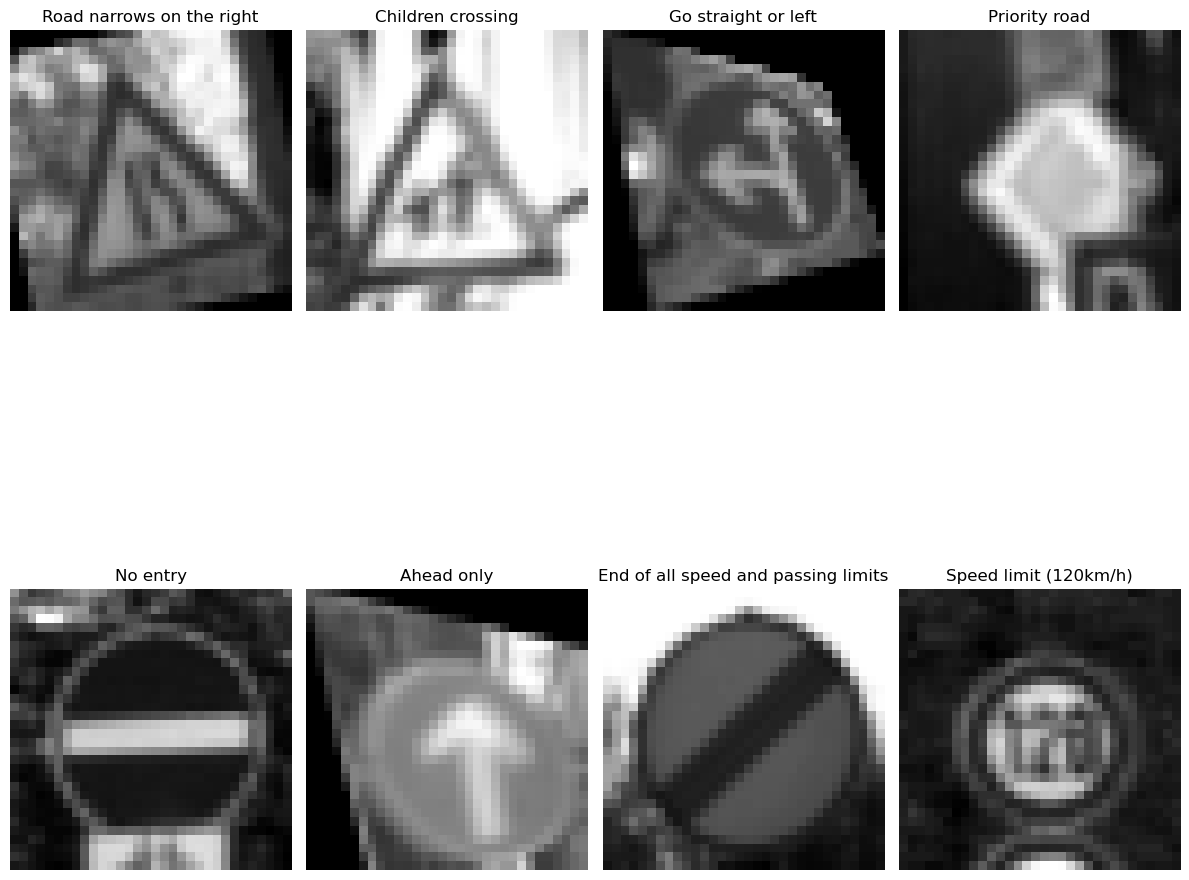

In [11]:
# divided by 127.5 -> let the pixel value between 0~2, since the original pixel value is 255
# minus by 1 -> let the pixel value between -1~1
x_train_normalized=x_train/127.5-1
x_valid_normalized=x_valid/127.5-1
x_test_normalized=x_test/127.5-1

count_to_show=8
figures={}
count=0
for i in random_signs:
    labels[count]=name_values[y_train[i]][1].decode('ascii')
    figures[count]=x_train_normalized[i].squeeze()
    count+=1

plot_figures(figures, 2, 4, labels)

In [12]:
# re-assign normalized dataset to original dataset
x_train=x_train_normalized
x_valid=x_valid_normalized
x_test=x_test_normalized

### Step 3: Design LeNet5 Model for Training and Validation

#### Building LeNet5 Model based on Definition

In [13]:
from tensorflow.keras import layers, models

model=models.Sequential()
# Conv 32x32x1 -> 28x28x6
model.add(layers.Conv2D(filters=6, kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu',data_format='channels_last',input_shape=(32,32,1)))
# Maxpool 28x28x6 -> 14x14x6
model.add(layers.MaxPooling2D((2,2)))
# Conv 14x14x6 -> 10x10x6
model.add(layers.Conv2D(16,(5,5),activation='relu'))
# Maxpool 10x10x6 -> 5x5x16
model.add(layers.MaxPooling2D((2,2)))
# Flatten 5x5x16 -> 400
model.add(layers.Flatten())
# Full connect 400 -> 120
model.add(layers.Dense(120,activation='relu'))
# Full connect 120 -> 84
model.add(layers.Dense(84,activation='relu'))
model.add(layers.Dropout(0.2))
# Fully connect output 43 classes(due to 43 classes in German Traffic Signs)
model.add(layers.Dense(43,activation='softmax'))


# show the summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

#### Training Model and Evaluation

In [14]:
# setup Early-Stopping criteria
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# specify optimizer, loss function and metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# start training with specified batch_size and epochs
batch_size=128
epochs=100
LeNet5=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/100
931/931 [==============================] - 13s 14ms/step - loss: 1.5911 - accuracy: 0.5689 - val_loss: 0.6852 - val_accuracy: 0.8164
Epoch 2/100
931/931 [==============================] - 16s 17ms/step - loss: 0.6163 - accuracy: 0.8236 - val_loss: 0.4419 - val_accuracy: 0.8785
Epoch 3/100
931/931 [==============================] - 19s 20ms/step - loss: 0.4283 - accuracy: 0.8755 - val_loss: 0.3334 - val_accuracy: 0.9068
Epoch 4/100
931/931 [==============================] - 13s 13ms/step - loss: 0.3304 - accuracy: 0.9026 - val_loss: 0.2543 - val_accuracy: 0.9287
Epoch 5/100
931/931 [==============================] - 13s 14ms/step - loss: 0.2709 - accuracy: 0.9190 - val_loss: 0.2090 - val_accuracy: 0.9409
Epoch 6/100
931/931 [==============================] - 13s 14ms/step - loss: 0.2336 - accuracy: 0.9293 - val_loss: 0.1941 - val_accuracy: 0.9441
Epoch 7/100
931/931 [==============================] - 13s 14ms/step - loss: 0.2019 - accuracy: 0.9383 - val_loss: 0.1782 - val_ac

In [15]:
model.evaluate(x=x_test, y=y_test)

395/395 [==============================] - 1s 2ms/step - loss: 0.5883 - accuracy: 0.9257


[0.5883229374885559, 0.9257323741912842]

#### Output the Trainging and Validation Related Curves & Confusion Matrix

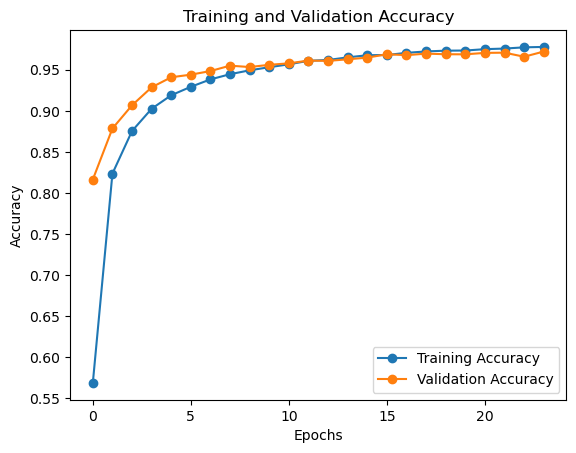

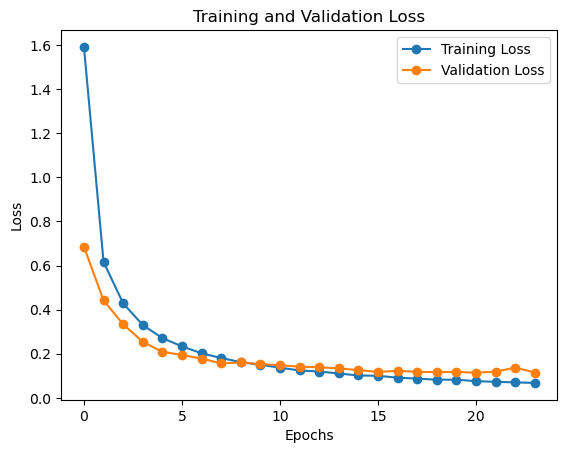

In [19]:
# plot accuracy curves
plt.plot(LeNet5.history['accuracy'], '-o')
plt.plot(LeNet5.history['val_accuracy'], '-o')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# plot loss curves
plt.plot(LeNet5.history['loss'], '-o')
plt.plot(LeNet5.history['val_loss'], '-o')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

395/395 [==============================] - 1s 2ms/step


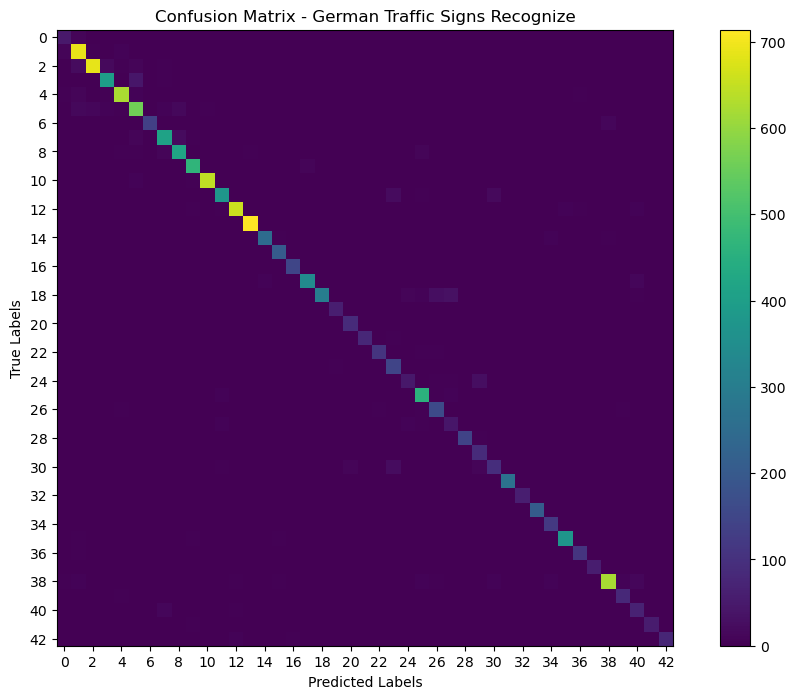

In [47]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred=model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix - German Traffic Signs Recognize')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(0, 43, step=2))
plt.yticks(np.arange(0, 43, step=2))
plt.show()

### Step 4: Test Model on New Images